<a href="https://colab.research.google.com/github/sarahklock/SDCB/blob/main/hamilton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarefas semana 15/06**
- kmeans aplicado aos pontos
- calcular matriz de pesos com base na distancia cartesiana
- aplicar as curvas de hilbert space-filling nos grupos
- descobrir os pontos mais proximos entre grupos adjacentes, segundo a curva de hilbert

# Importações

In [ ]:
# importando drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!cp -r '/drive/Shareddrives/Tcc2021AS/code/dvTools_pasta' ./dvTools
!cp -r '/drive/Shareddrives/Tcc2021AS/code/4 - testes_dvTools/lib' ./dvTools_mod

In [ ]:
# importando libs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

import json
import time
import random
import math

from dvTools.dvTools.Grafo import Grafo
from dvTools.dvTools.Caminhos import Caminhos
import dvTools_mod

In [ ]:
# importando arquivo
g = Grafo('./dvTools/grafo2.json')

#Rascunho     ....

In [ ]:
i = Grafo('exemplo4.json')

In [ ]:
distance(i)

# Gerador de malha

In [ ]:
MESH_FLOAT = 10 # Vai flutuar em até 10% o valor correto da distância

def genmesh(n, minX = -256, maxX = 255, minY = -256, maxY = 255):
  global MESH_FLOAT

  mesh = dict()
  for point in range(n):
    mesh[point] = { 'coords': [ random.randint(minX, maxX), random.randint(minY, maxY) ] }
    mesh[point]['edges'] = list()
    mesh[point]['weights'] = list()
  for edge in range(n):
    for i in range(n):
      if (i != edge):
        origin, destiny = edge, i
        if (origin == destiny):
          destiny += 1
        mesh[origin]['edges'].append(destiny)

        distance = ( (mesh[origin]['coords'][0] - mesh[destiny]['coords'][0]) ** 2 +
                     (mesh[origin]['coords'][1] - mesh[destiny]['coords'][1]) ** 2 ) ** 1/2

        distance += (distance * random.randint(-MESH_FLOAT, MESH_FLOAT)) / 100 # Faz a flutuação para mais ou menos

        mesh[origin]['weights'].append(distance)
  return mesh

## Gerando uma malha aleatória

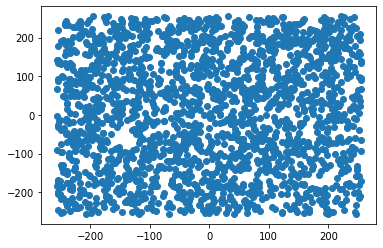

In [ ]:
n_points = 2048
graph = dvTools_mod.Graph(data = genmesh(n_points))
graph.plot(edges = False)

### Aplicando Kmeans na malha gerada

In [ ]:
POINTS_PER_CLUSTERS = 4 # 4 é um número levemente abaixo de 8, o número ideal de pontos por cluster

k = int(len(graph) / POINTS_PER_CLUSTERS)
while True:
  kmeans = KMeans(n_clusters = k).fit(graph.coords_point())

  pointsperlabel = [ sum(kmeans.labels_ == label) for label in kmeans.labels_ ]

  if (max(pointsperlabel) <= 10): # Importante: o resultado só é válido quando um cluster não possui mais de 10 pontos
    break

  k += 1 # Caso qualquer cluster tenha mais de 10 pontos adiciona 1 ao número de k clusters a serem gerados e repete o processo

#### Plotando os centroides junto dos pontos


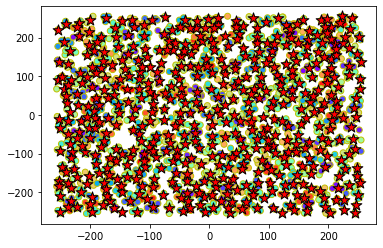

In [ ]:
plt.scatter([ point[0] for point in graph.coords_point() ],
            [ point[1] for point in graph.coords_point() ],
            c = kmeans.labels_,
            cmap = 'rainbow',
            edgecolor = 'y',)

plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            marker = '*',
            c = 'r',
            edgecolor = 'k',
            s = 128)

# Kmeans aplicado aos pontos

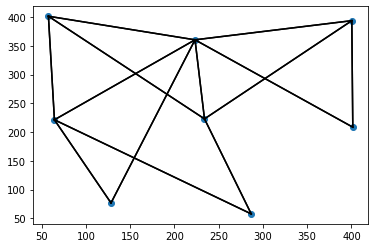

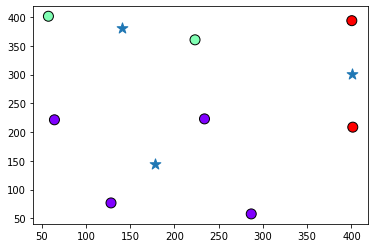

In [ ]:
arr = np.array(g.coords_point())
kmeans = KMeans(n_clusters = 3).fit(arr)

g.plot()

plt.scatter(# plota os pontos
    arr[:, 0], arr[:, 1], #x e y
    c = kmeans.labels_, #cores de acordo com o grupo
    marker='o', # pontos com 'o'
    edgecolor='black', #cor da borda
    cmap='rainbow', #esquema de cores
    s=100 #tamanho
)

plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    marker='*',
    s = 128)

In [ ]:
h = Grafo('exemplo3.json')

In [ ]:
arr2 = np.array(h.coords_point())
kmeans2 = KMeans(n_clusters = 2).fit(arr2)

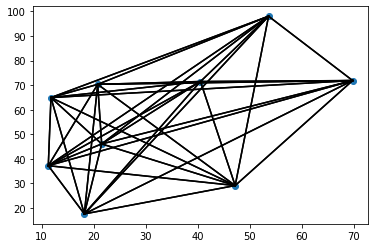

In [ ]:
h.plot()

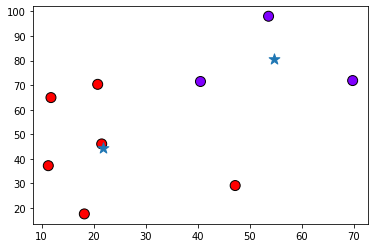

In [ ]:
plt.scatter(# plota os pontos
    arr2[:, 0], arr2[:, 1], #x e y
    c = kmeans2.labels_, #cores de acordo com o grupo
    marker='o', # pontos com 'o'
    edgecolor='black', #cor da borda
    cmap='rainbow', #esquema de cores
    s=100 #tamanho
)

plt.scatter(
    kmeans2.cluster_centers_[:, 0],
    kmeans2.cluster_centers_[:, 1],
    marker='*',
    s = 128)

2 3
3 4
4 1
1 5
5 0
0 7
7 6
6 8


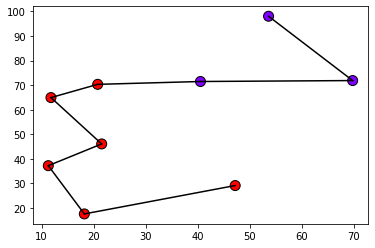

In [ ]:
ordem = [2, 3, 4, 1, 5, 0, 7, 6, 8]
for i in range(8):
  j = ordem[i]
  k = ordem[i+1]
  print(j, k)
  plt.plot([arr2[j][0], arr2[k][0]], [arr2[j][1], arr2[k][1]], c='k')

plt.scatter(# plota os pontos
    arr2[:, 0], arr2[:, 1], #x e y
    c = kmeans2.labels_, #cores de acordo com o grupo
    marker='o', # pontos com 'o'
    edgecolor='black', #cor da borda
    cmap='rainbow', #esquema de cores
    s=100 #tamanho
)

In [ ]:
distance(h)

# Calcular matriz de pesos com base na distancia cartesiana

A função seguinte aceita apenas pontos inteiros, ou seja, o indice dos pontos cadastrados no grafo. Existem três possibilidades para se inserir nos parâmetros:


*   **Apenas o grafo**: retorna a matriz inteira, comparando todos os pontos com todos os pontos 
*   **O grafo e um ponto**: retorna uma lista com as distâncias de todos os pontos em relação ao ponto especifico inserido.
*   **O grafo e dois pontos**: retorna apenas a distância entre esses dois pontos específicos.
*   **O grafo e centroid=True**: retorna a matriz com os ultimos integrantes sendo os centroides. Se quero saber as distancias ao centroide de grupo x, vou até a posição [-(x+1)] ou [-x-1]. Soma-se 1 para permitir que haja o grupo 0.
 *Exemplo*: distance(g, centroid=True)[-(0+1)]








In [ ]:
def distance(grafo, ponto1=None, ponto2=None, centroid=False, verbose=True):
  coords = grafo.coords_point()
  
  # Se centroid == True, os ultimos integrantes da matriz serao os centroides, para ser possivel calcular a distancia dos pontos para os centroides.
    # Eles poderão ser acessados de modo que, se quero saber as distancias ao centroide de grupo x, vou até a posição [-(x+1)] ou [-x-1]. Soma-se 1 para permitir que haja o grupo 0.
    # Exemplo: distance(g, centroid=True)[-(0+1)]
  if centroid: 
    for i in kmeans.cluster_centers_:
      coords.append(None)
    j = 1
    for i in kmeans.cluster_centers_:
      coords[-j] = tuple(i)
      j += 1
     
  
  if ponto2 == None:
    matriz = []

    if ponto1 == None: 
      # Se não forem inseridos nenhum dos pontos, retorna a matriz inteira.
      if verbose:
        print("Calculando as distancias de todos os pontos entre si...")

      i = 0
      for ponto1 in coords:
        matriz.append([])
        
        for ponto2 in coords:
          distancia = ((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2)**(1/2)
          
          matriz[i].append(distancia)
        i += 1

      return matriz
    
    else:
      # Se for inserido apenas 1 ponto, retorna uma lista com as distancia dele entre os outros.
      if verbose:
        print(f"Calculando as distancias de todos os pontos ao ponto {ponto1}...")
      
      ponto1 = coords[ponto1]
      
      for ponto2 in coords:
        distancia = ((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2)**(1/2)
        
        matriz.append(distancia)

      return matriz

  else:
    if type(ponto2) == int:
      # Se forem inseridos 2 pontos, retorna apenas a distancia entre eles.
      if verbose:
        print(f"Calculando a distancia entre o ponto {ponto1} e o ponto {ponto2}...")

      ponto1 = coords[ponto1]
      ponto2 = coords[ponto2]

      matriz = ((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2)**(1/2)
      return matriz 

    elif type(ponto2) == list:
      #se for add ponto 1 e uma lista em ponto2, retorna uma lista com a distancia entre ponto1 e todos os em ponto2
      matriz = []

      if verbose:
        print(f"Calculando as distancias do {ponto1} até os pontos {ponto2}...")

      ponto1 = coords[ponto1]

      j = 0
      for i in ponto2:
        ponto2[j] = coords[i]
        j=j+1
      
      for ponto in ponto2:
        distancia = ((ponto1[0] - ponto[0])**2 + (ponto1[1] - ponto[1])**2)**(1/2)
        
        matriz.append(distancia)

      return matriz


In [ ]:
distance(g)

In [ ]:
distance(g,5)

In [ ]:
distance(g,6)

In [ ]:
distance(g,centroid=True)

A função seguinte funciona apenas para coordenadas exatas, para facilitar às contas com os centróides.

In [ ]:
# Função que aceita coordenadas exatas.

def distance_coords(coord1, coord2, grafo=None):
  return ((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)**(1/2)

In [ ]:
distance_coords([1,1],[1,2])

# Algoritimo curvas de hilbert space-filling

In [ ]:
HILBERT_SFC_0 = ( (0, 0), (0, 1), (1, 1), (1, 0) )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def hilbert_sfc_gen_curve(order):
  if (order < 0):
    raise ValueError('Pseudo Hilbert space filling curve must be in positive order')
  global HILBERT_SFC_0

  output = np.array(HILBERT_SFC_0)
  
  for cur_order in range(1, order + 1):
    offset = 2 ** cur_order

    bottom_left = output[:, [1, 0]].tolist()
    top_left = (output + (0, offset)).tolist()
    top_right = (output + offset).tolist()
    bottom_right = (((offset * 2) - 1, offset - 1) - output[:, [1, 0]]).tolist()

    output = np.array(bottom_left + top_left + top_right + bottom_right)
  
  return output

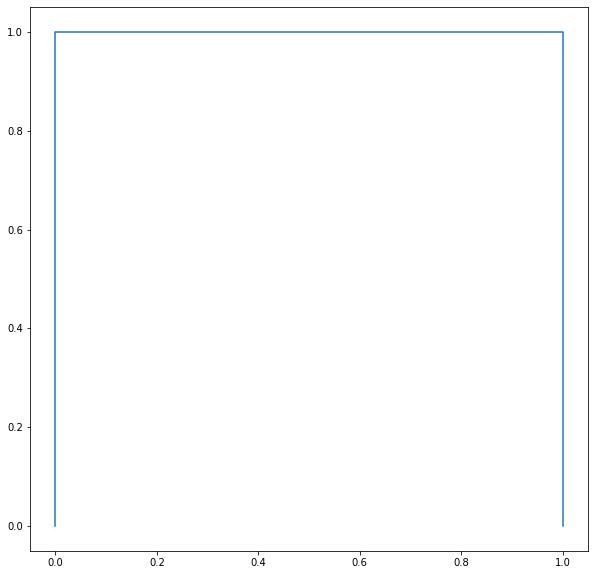

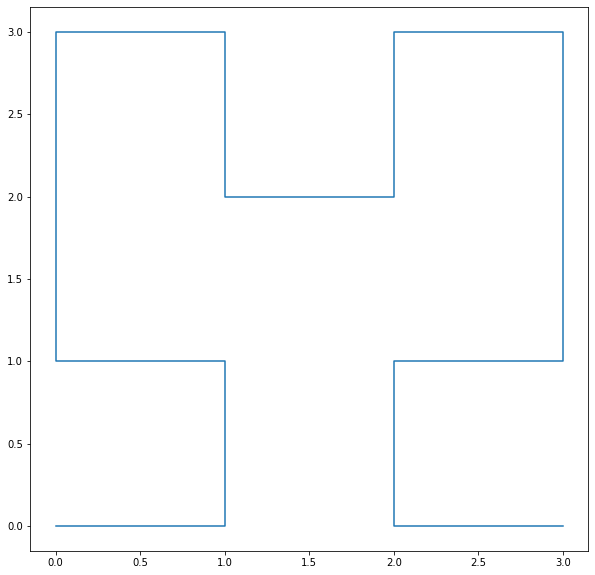

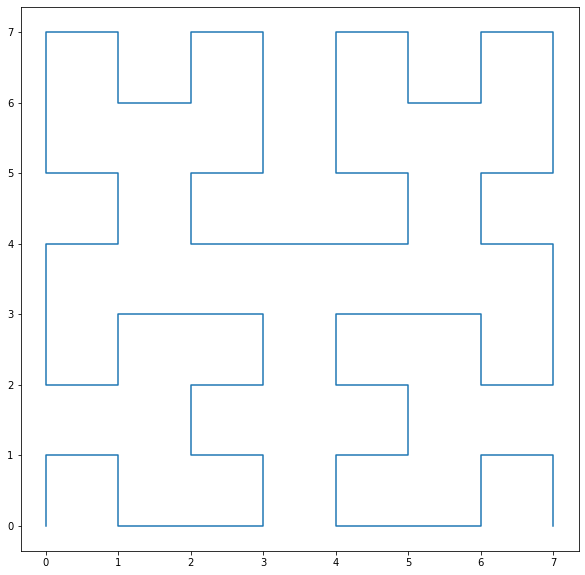

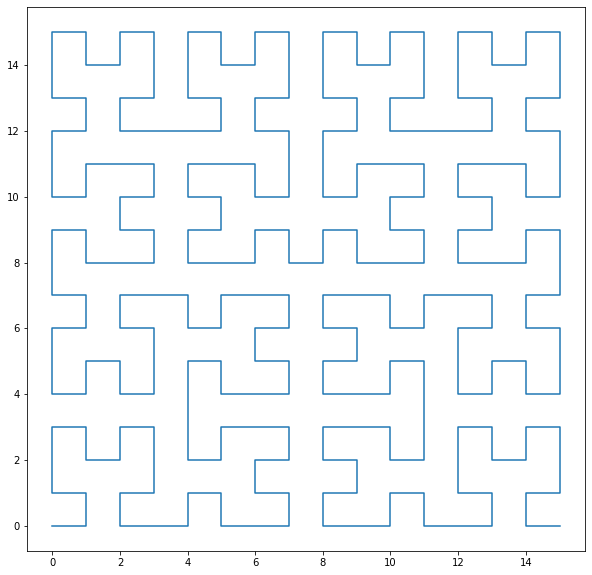

In [ ]:
for hsfc in [hilbert_sfc_gen_curve(i) for i in range(4)]:
  plt.figure(figsize=(10, 10))
  plt.plot(hsfc[:, 0], hsfc[:, 1])
  plt.show()

In [ ]:
def hilbert_sfc_pos_to_point(pos, order):
  if (order < 0):
    raise ValueError('Pseudo Hilbert space filling curve must be in positive order')
  if (pos >= (4 ** (order + 1))):
    raise ValueError(f'The position {pos} is not part of the order {order}')
  global HILBERT_SFC_0

  n_squares = 2 ** order
  n_points = n_squares ** 2

  index = pos % 4
  output = HILBERT_SFC_0[index]

  for cur_order in range(1, order + 1):
    pos = pos // 4
    n_square = pos % 4
    offset = 2 ** cur_order

    if (n_square == 0):
      output = [output[1], output[0]]
    elif (n_square == 1):
      output = [output[0], output[1] + offset]
    elif (n_square == 2):
      output = [output[0] + offset, output[1] + offset]
    else:
      output = [(2 * offset) -1 - output[1], offset - 1 - output[0]]
  
  return output

In [ ]:
def hilbert_sfc_half_square_x(square, left):
  return ((square[0][0], (square[0][0] + square[0][1]) / 2) if left else
          ((square[0][0] + square[0][1]) / 2, square[0][1]))

def hilbert_sfc_half_square_y(square, bottom):
  return ((square[1][0], (square[1][0] + square[1][1]) / 2) if bottom else
          ((square[1][0] + square[1][1]) / 2, square[1][1]))

def hilbert_sfc_half_square(square, left, bottom):
  return (hilbert_sfc_half_square_x(square, left),
          hilbert_sfc_half_square_y(square, bottom))

def hilbert_sfc_point_to_pos(point, order, square):
  multiplier = ((0, 1, 2, 3),
                (0, 3, 2, 1),
                (2, 3, 0 ,1),
                (2, 1, 0, 3))

  rot_update = ((1, 0, 0, 3),
                (0, 2, 1, 1),
                (2, 1, 3, 2),
                (3, 3, 2, 0))
  out, rot = 0, 0
  for it in range(order + 1):
    leftX = point[0] <= (square[0][0] + square[0][1]) / 2
    bottomY = point[1] <= (square[1][0] + square[1][1]) / 2

    square = hilbert_sfc_half_square(square, leftX, bottomY)

    if (leftX and bottomY):
      index = 0
    elif (leftX and (not bottomY)):
      index = 1
    elif ((not leftX) and (not bottomY)):
      index = 2
    else:
      index = 3

    out += multiplier[rot][index] * (4 ** (order - it))
    rot = rot_update[rot][index]

  return out

In [ ]:
def hilbert_sfc_sorted(points):
  rectangle = ((np.min(points[:, 0]),
                np.max(points[:, 0])),
                (np.min(points[:, 1]),
                np.max(points[:, 1])))
  max_width = np.max([rectangle[0][1] - rectangle[0][0],
                      rectangle[1][1] - rectangle[1][0]])
  square = ((rectangle[0][0], rectangle[0][0] + max_width),
            (rectangle[1][0], rectangle[1][0] + max_width))
  del rectangle
  order = math.ceil(math.log(len(points), 2) -  1)

  out = [ i for i in range(len(points)) ]

  return sorted(out, key = lambda x : hilbert_sfc_point_to_pos(points[x], order, square))

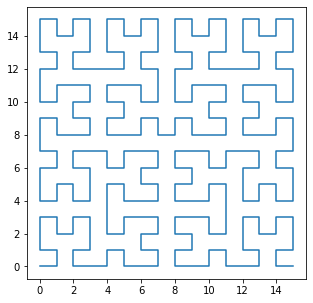

In [ ]:
N = 3

arr = hilbert_sfc_gen_curve(N)
plt.figure(figsize = (5, 5))
plt.plot(arr[:, 0], arr[:, 1])

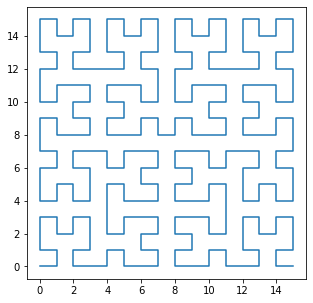

In [ ]:
N = 3

arr = np.array([ hilbert_sfc_pos_to_point(i, N) for i in range(4 ** (N + 1)) ])
plt.figure(figsize = (5, 5))
plt.plot(arr[:, 0], arr[:, 1])

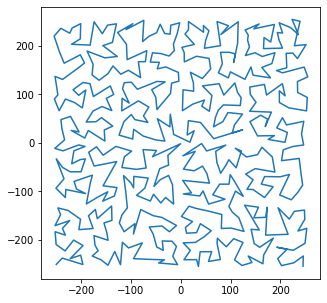

In [ ]:
arr = np.array([ kmeans.cluster_centers_[i] for i in hilbert_sfc_sorted(kmeans.cluster_centers_) ])
plt.figure(figsize = (5, 5))
plt.plot(arr[:, 0], arr[:, 1])

# Descobrir os pontos mais proximos entre grupos adjacentes, segundo a curva de hilbert

### *Retorna uma lista com listas o numero dos pontos de cada grupo, de acordo com o índice.*

In [ ]:
def group_points(grafo):
  array = []
  for i in kmeans.cluster_centers_: # Adiciona uma lista na lista, com a posição 0 recebendo o centroide.
    array.append([])

  j = 0
  for i in kmeans.labels_:
    array[i].append(j)
    j += 1
  
  return array

In [ ]:
group_points(g)

[[7, 22, 51, 73, 76, 103],
 [70, 75, 104, 108],
 [29, 32, 105, 126],
 [37, 39, 113],
 [3, 12, 44, 52, 82, 94, 97],
 [5, 16, 69, 123],
 [88],
 [50, 55, 65, 66, 78, 87, 124],
 [6, 18, 79, 81, 116],
 [8, 53, 91, 93, 110, 118],
 [1, 17, 74, 98],
 [28, 63, 77, 109],
 [21, 24, 45],
 [42, 49, 64, 107, 117],
 [35, 86, 101, 114],
 [20, 54, 68, 115, 119],
 [26, 47, 48, 80, 125],
 [19, 30, 34, 72, 83, 112],
 [23, 46, 56, 62, 99],
 [14, 85, 95, 102, 106],
 [11, 36, 90],
 [9, 31, 84],
 [2, 96],
 [13, 25, 58, 71, 120],
 [0, 15, 33, 100, 121],
 [59],
 [10, 40, 60, 89],
 [38, 92, 127],
 [43, 57, 61, 122],
 [41, 67],
 [27],
 [4, 111]]

#### Testes

In [ ]:
array_points = np.array(g.coords_point())

##### Analitico

In [ ]:
def labels():
  group = group_points(g)
  output = []

  for i in range(len(array_points)):
    for j in range(len(group)):
      if (i in group[j]):
        output.append(j)
        break
  return output

if (np.all(kmeans.labels_ == labels())):
  print('Passou')
else:
  print('Nao passou')

Passou


##### Visual

Segragacao de pontos segundo kmeans


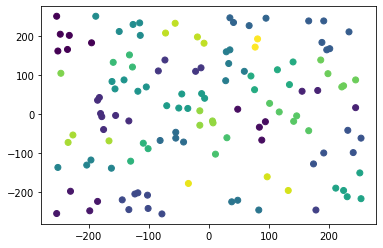

Segregacao de pontos


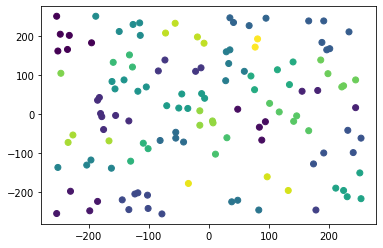

In [ ]:
print('Segragacao de pontos segundo kmeans')
plt.scatter(array_points[:, 0],
            array_points[:, 1],
            c = kmeans.labels_)
plt.show()

print('Segregacao de pontos')
plt.scatter(array_points[:, 0],
            array_points[:, 1],
            c = labels())
plt.show()

### *Ponto mais proximo ao centroide, ponto mais proximo ao centroide*

Inútil. Faz o mesmo número de comparações que a "Ponto mais próximo ao centróide, ponto mais próximo" e é menos precisa. Chega a ser até ilógica.

In [ ]:
def between_centroids(order, grafo):
  pontosDeConexao = []
  pontos_grupo = group_points(grafo)
  matriz = distance(grafo, centroid=True)

  for group in range(len(order)-1):
    # Impedindo que o ponto incial de um grupo seja igual ao último. last_point é gerada na parte 3.
    rearranjo_pontos = pontos_grupo[order[group]]
    if not group == 0:
      rearranjo_pontos.remove(last_point)

    # Encontra o ponto do grupo seguinte mais proximo ao centroide.
    vetor = matriz[-order[group+1]-1]
    distancia = -1

    for point in rearranjo_pontos:
      if vetor[point] < distancia or distancia == -1:
        distancia = vetor[point]
        pontos_conexao = point
    
    pontos_conexao = [pontos_conexao, None]

    # Encontra o ponto do grupo seguinte mais proximo ao centroide.
    vetor = matriz[-order[group]-1]
    distancia = -1

    for point in pontos_grupo[order[group+1]]:
      if vetor[point] < distancia or distancia == -1:
        distancia = vetor[point]
        pontos_conexao[1] = point
    
    last_point = pontos_conexao[1]

    pontosDeConexao.append(pontos_conexao)
  
  return pontosDeConexao

In [ ]:
between_centroids([0,1,2], g)

Calculando as distancias de todos os pontos entre si...


[[76, 75], [70, 29]]

### *Ponto mais proximo ao centróide, ponto mais proximo*

Tanto nessa função quanto na proxima, "Força bruta: ponto próximo, ponto próximo", dá-se a opção de adicionar uma matriz com os pesos. Caso não seja adicionado, usaremos a matriz de distancias cartesianas.

In [ ]:
def conecting_centroid(order, grafo, matriz=None):
  pontos_proximos = []
  pontos_grupo = group_points(grafo)
  
  # Pode adicionar uma matriz com os pesos. Caso não acontecer, a função usará a matriz de distancias cartograficas.
  if matriz==None:
    matriz = distance(grafo, centroid=True)

  for group in range(len(order)-1):
    
    # Impedindo que o ponto incial de um grupo seja igual ao último. last_point é gerada na parte 2.
    rearranjo_pontos = pontos_grupo[order[group]]
    if not group == 0:
      rearranjo_pontos.remove(last_point)

    # Encontra o ponto do grupo seguinte mais proximo ao centroide.
    vetor = matriz[-order[group]-1]
    distancia = -1

    for point in pontos_grupo[order[group+1]]:
      if vetor[point] < distancia or distancia == -1:
        distancia = vetor[point]
        pontos_conexao = point
    
    last_point = pontos_conexao
    pontos_conexao = [None, pontos_conexao]

    # Encontra o ponto mais próximo do ponto de conexão.
    p_matriz = matriz[pontos_conexao[1]]
    distancia = -1

    for point in rearranjo_pontos:
      if p_matriz[point] < distancia or distancia == -1:
        distancia = p_matriz[point]
        pontos_conexao[0] = point
    
    pontos_proximos.append(pontos_conexao)
  
  return pontos_proximos     

In [ ]:
conecting_centroid([0,1,2], g)

Calculando as distancias de todos os pontos entre si...


[[76, 75], [70, 29]]

### *Força bruta: ponto próximo, ponto próximo*

In [ ]:
def conection_points(ordem, grafo, matriz=None):
  pontos_grupo = group_points(grafo)
  pontosDeConexao = []
  last_point = -1
  # Pode adicionar uma matriz com os pesos. Caso não acontecer, a função usará a matriz de distancias cartograficas.
  if matriz==None:
    matriz = distance(grafo)
  
  for i in range(len(ordem)-1):
    distancia = -1

    for j in pontos_grupo[ordem[i]]:
      for k in pontos_grupo[ordem[i+1]]:
        if not j == last_point:
          if matriz[j][k] < distancia or distancia == -1:
            distancia = matriz[j][k]
            pontos = [j,k]
    
    last_point = pontos[1]
    pontosDeConexao.append(pontos)
  
  return pontosDeConexao    

In [ ]:
conection_points([0,1,2],g)

Calculando as distancias de todos os pontos entre si...


[[76, 75], [70, 29]]

# Testes & Comparações

In [ ]:
# Essa celula usa o grafo pronto

g = Grafo('./dvTools/grafo2.json')
array_points = np.array(g.coords_point())
kmeans = KMeans(n_clusters = 3).fit(array_points)

In [ ]:
# Essa celula usa um grafo aleatorio

n_points = 128

g = dvTools_mod.Graph(data = genmesh(n_points))
array_points = np.array(g.coords_point())

kmeans = None
POINTS_PER_CLUSTERS = 4 # 4 é um número levemente abaixo de 8, o número ideal de pontos por cluster
k = int(len(array_points) / POINTS_PER_CLUSTERS)
while True:
  kmeans = KMeans(n_clusters = k).fit(array_points)
  pointsperlabel = [ sum(kmeans.labels_ == label) for label in kmeans.labels_ ]
  if (max(pointsperlabel) <= 10): # Importante: o resultado só é válido quando um cluster não possui mais de 10 pontos
    break
  k += 1 # Caso qualquer cluster tenha mais de 10 pontos adiciona 1 ao número de k clusters a serem gerados e repete o processo

In [ ]:
order = hilbert_sfc_sorted(kmeans.cluster_centers_)

In [ ]:
def itop(graph, order, function): # Index to Points, mas com um nome mais radical e menos cafona 😎
  output = []
  for pair in function(order, graph):
    output.append([array_points[pair[0]],
                   array_points[pair[1]]])
  return output

In [ ]:
print(f'A ordem vai ser: {order}')

A ordem vai ser: [1, 11, 21, 6, 22, 8, 23, 14, 31, 3, 13, 17, 25, 5, 9, 2, 29, 12, 20, 7, 19, 24, 0, 27, 30, 15, 28, 16, 4, 26, 18, 10]


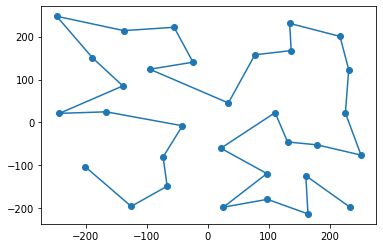

In [ ]:
centers = np.array([ kmeans.cluster_centers_[n] for n in order ])

plt.plot(centers[:, 0],
         centers[:, 1])
plt.scatter(centers[:, 0],
            centers[:, 1])

Label 1


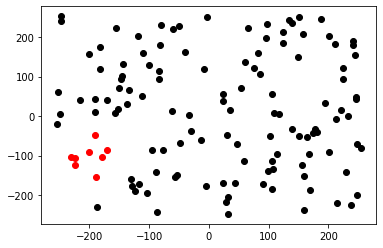

Label 11


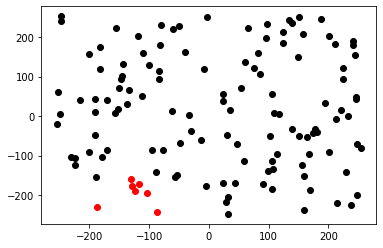

Label 21


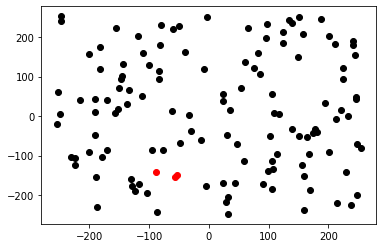

Label 6


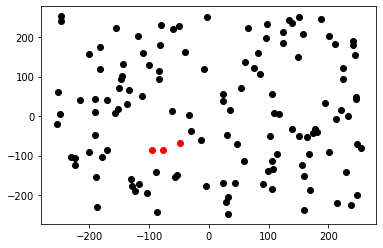

Label 22


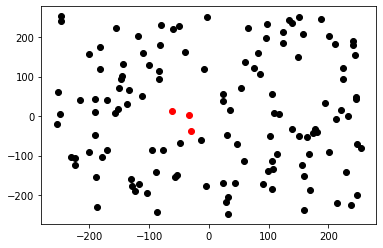

Label 8


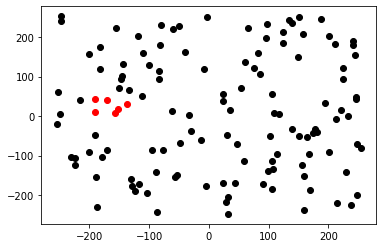

Label 23


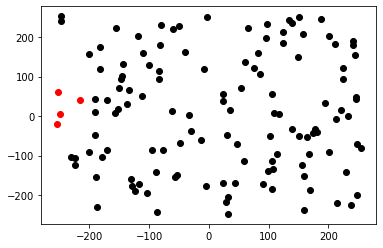

Label 14


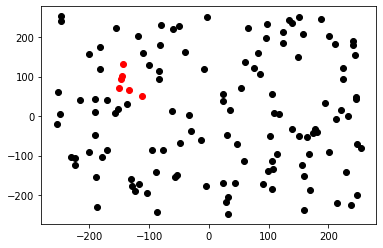

Label 31


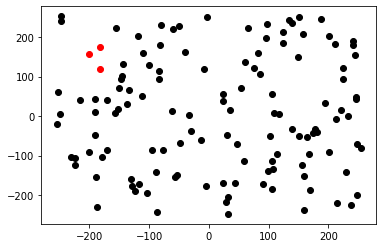

Label 3


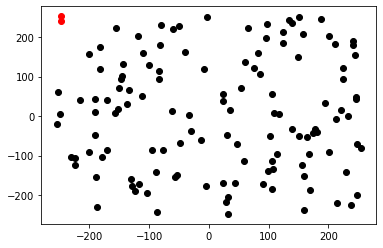

Label 13


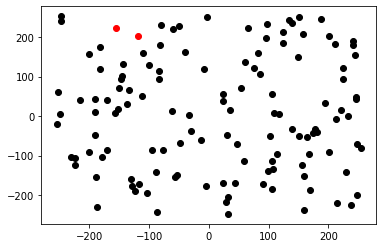

Label 17


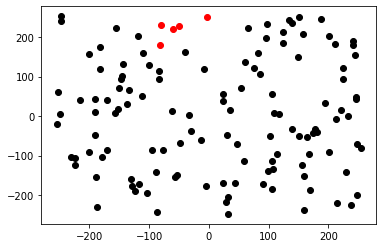

Label 25


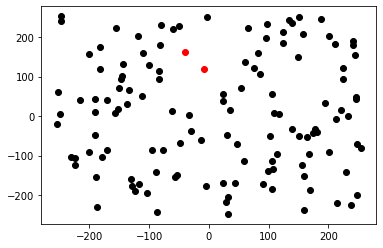

Label 5


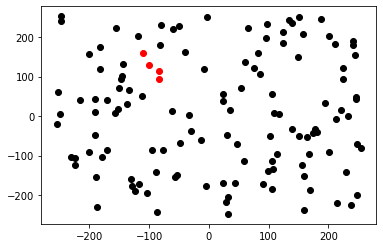

Label 9


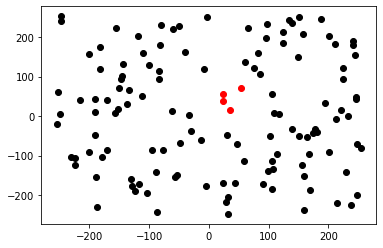

Label 2


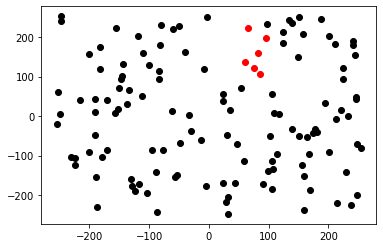

Label 29


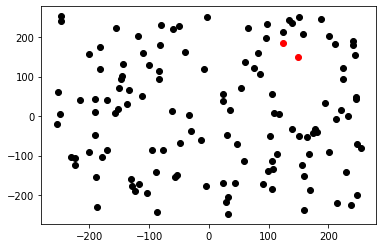

Label 12


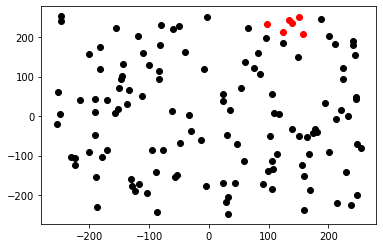

Label 20


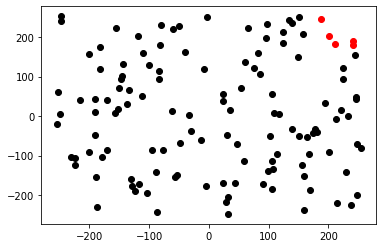

Label 7


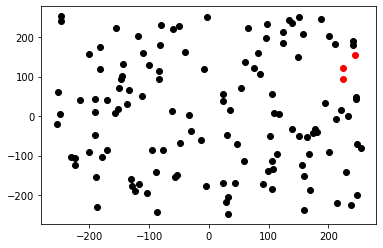

Label 19


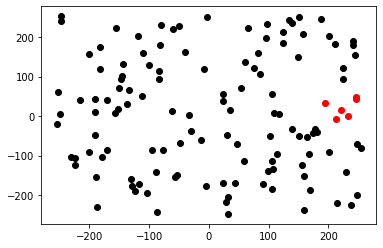

Label 24


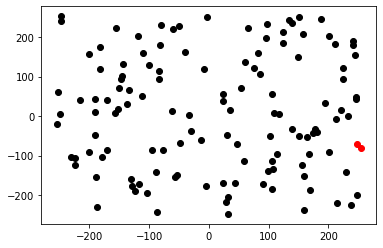

Label 0


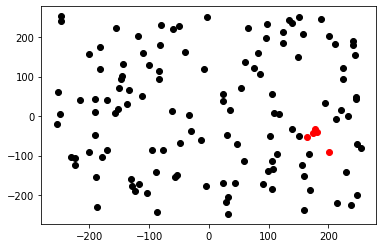

Label 27


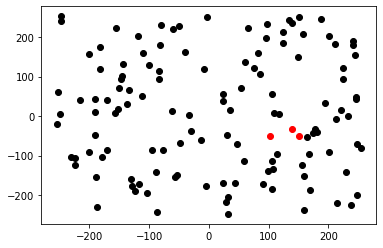

Label 30


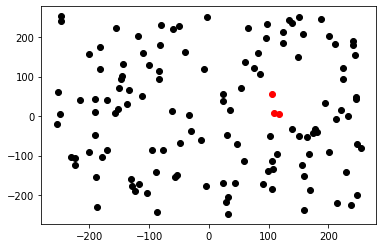

Label 15


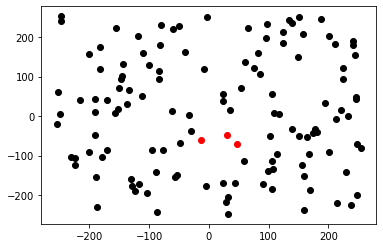

Label 28


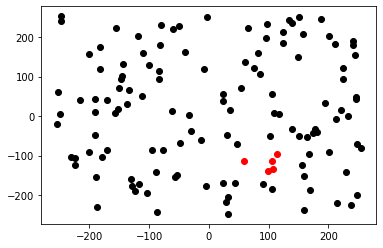

Label 16


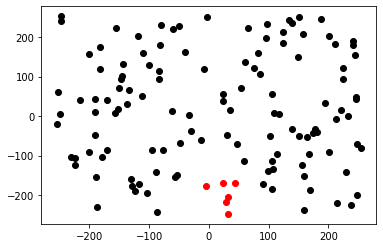

Label 4


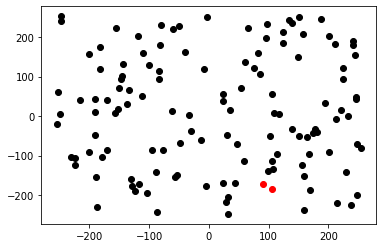

Label 26


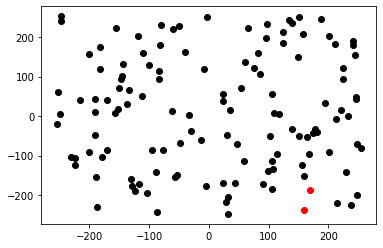

Label 18


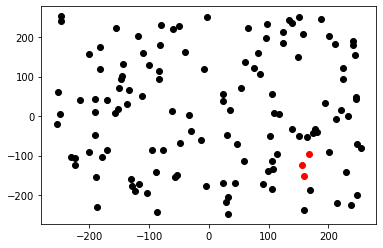

Label 10


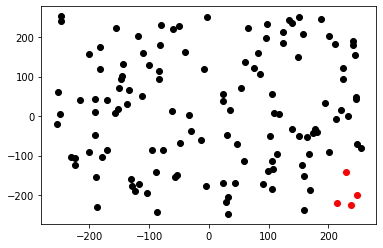

In [ ]:
for label in order:
  print(f'Label {label}')
  plt.scatter(array_points[ kmeans.labels_ == label, 0 ],
              array_points[ kmeans.labels_ == label, 1 ],
              c = 'r')
  plt.scatter(array_points[ kmeans.labels_ != label, 0 ],
              array_points[ kmeans.labels_ != label, 1 ],
              c = 'k')
  plt.show()

Calculando as distancias de todos os pontos entre si...
Custo inter-grupos: 1886.0696654907395


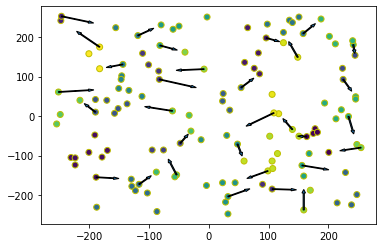

Calculando as distancias de todos os pontos entre si...
Custo inter-grupos: 1862.1498965789226


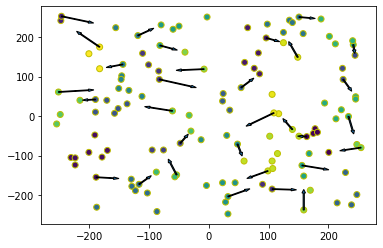

Calculando as distancias de todos os pontos entre si...
Custo inter-grupos: 1868.6659924495414


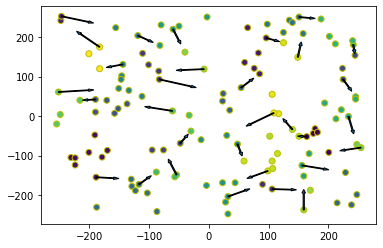

In [ ]:
for function in [between_centroids, conecting_centroid, conection_points]: # Python aceita uma funcao ser passada por parametro 🤔
  pairs = itop(g, order, function)
  cost = 0
  for pair in pairs:
    cost += math.sqrt( ((pair[0][0] - pair[1][0]) ** 2) +
                       ((pair[0][1] - pair[1][1]) ** 2) )

  print(f'Custo inter-grupos: {cost}')

  for pair in pairs:
    plt.arrow(pair[0][0],
              pair[0][1],
              (pair[1][0] - pair[0][0]) / 2,
              (pair[1][1] - pair[0][1]) / 2,
              width = 2)

  '''
  plt.scatter(kmeans.cluster_centers_[:, 0],
              kmeans.cluster_centers_[:, 1],
              marker = '*',
              edgecolor = 'k',
              s = 128)
  '''
  
  plt.scatter(array_points[:, 0],
              array_points[:, 1],
              edgecolor = 'y',
              c = kmeans.labels_)

  plt.show()

# Lixo

In [ ]:
# Encontra primeiro o mais próximo ao centróide e depois o mais proximo ao mais próximo ao centroide.

def between_centroids0(order, grafo):
  pontos_proximos = []
  pontos_grupo = group_points(grafo)
  coordenadas = g.coords_point()

  for group in range(len(order)-1):

    # Encontra o ponto do grupo seguinte
    distancia = -1
    
    for point in pontos_grupo[order[group+1]]:
      if distancia > distance_coords(kmeans.cluster_centers_[order[group]], coordenadas[point]) or distancia == -1:
        distancia = distance_coords(kmeans.cluster_centers_[order[group]], coordenadas[point])
        pontos_conexao = point
        
    pontos_conexao = [None,pontos_conexao]

    # Encontra o ponto mais próximo do ponto de conexão.
    distancia = -1

    for point in pontos_grupo[order[group]]:
      if distancia > distance_coords(kmeans.cluster_centers_[order[group]], coordenadas[point]) or distancia == -1:
        distancia = distance_coords(kmeans.cluster_centers_[order[group]], coordenadas[point])
        pontos_conexao[0] = point
    
    pontos_proximos.append(pontos_conexao)
  
  return pontos_proximos     

In [ ]:
between_centroids0([0,1,2], g)

[[6, 5], [5, 2]]

In [ ]:
def entre_grupos(ordem, grafo):
  pontos_grupo = group_points(grafo)
  coordenadas = g.coords_point()
  pontosDeConexao = []
  
  for i in range(len(ordem)-1):
    distancia = -1

    for j in pontos_grupo[ordem[i]]:
      for k in pontos_grupo[ordem[i+1]]:
        if distance_coords(coordenadas[j], coordenadas[k]) < distancia or distancia == -1:
          distancia = distance_coords(coordenadas[j], coordenadas[k])
          pontos = [j,k]
        
    pontosDeConexao.append(pontos)
  
  return pontosDeConexao    

In [ ]:
entre_grupos([0,1,2], g)

[[4, 5], [2, 3]]